Train multiple classifiers (at least 6, of varying degrees of complexity and character (parametric, nonparametric, linear, nonlinear,...) on multiple training-test splits of the data. Compare classification performance.

Pay particular attention to the following;
- imbalance between classes, how you handle this
- classification accuracy, specificity and sensitivity overall, and at the class level.

Be careful about using the full data set for any training/validation steps. For example, exploration and dimension reduction, if you choose to pursue this approach, should be done of the training data only.

Make sure to discuss:

*Overall performance and how you assess this*

*Are all or only some classes well separated* 

*Class imbalance, modeling assumptions, training metrics*

*The full training pipeline you set up and motivate all your choices*

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import math
from itertools import zip_longest
import random
from feature_selection import get_elastic_importances, get_lasso_importances, get_anova_importances
from collections import defaultdict
from sklearn.feature_selection import f_classif
#to get rid of the warning
import warnings
warnings.filterwarnings('ignore')


In [4]:

data = pd.read_csv('Fish3.txt', delimiter=' ')

X = data.drop('Species', axis=1)
target = data['Species']
# print('Training data shape:', X_train.shape)
# print('Testing data shape:', X_test.shape)
# print('Target shape:', target.shape)
print(data.head())
print(X.head())

       Weight         L1         L2         L3     Height      Width Species
1  170.530305  19.323169  22.913269  23.887829  25.233577  14.826372   Perch
2  493.721354  28.299621  31.028229  34.917027  37.856243  13.675772   Bream
3   33.657735  17.435741  18.072636  23.489747  26.765675  13.660683   Roach
4  584.259843  32.491349  33.126297  39.298082  37.610853  13.622560   Bream
5  970.375723  37.122510  39.817489  42.473488  29.878001  17.403387   Perch
       Weight         L1         L2         L3     Height      Width
1  170.530305  19.323169  22.913269  23.887829  25.233577  14.826372
2  493.721354  28.299621  31.028229  34.917027  37.856243  13.675772
3   33.657735  17.435741  18.072636  23.489747  26.765675  13.660683
4  584.259843  32.491349  33.126297  39.298082  37.610853  13.622560
5  970.375723  37.122510  39.817489  42.473488  29.878001  17.403387


#### Visualize the data based on different Species:

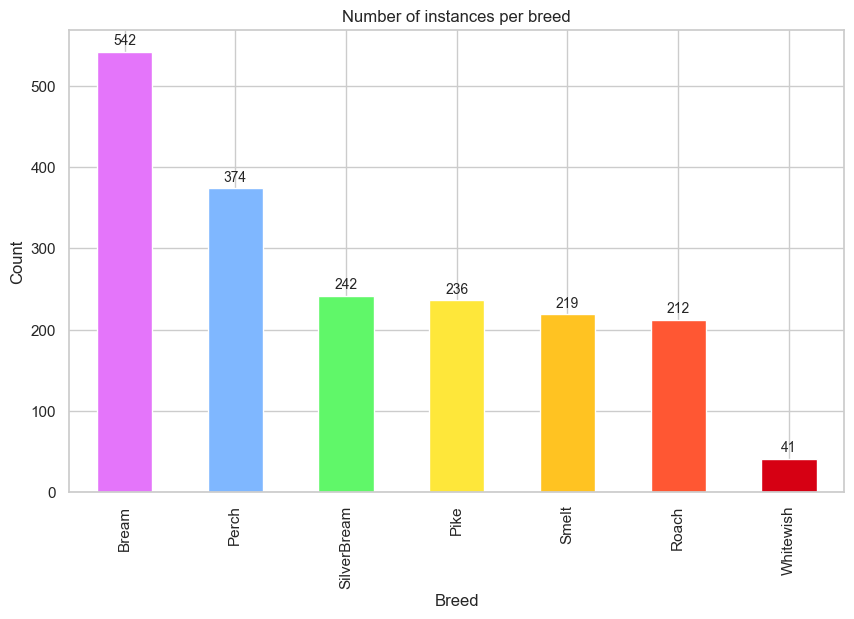

In [401]:
colors1 = ['#E475FA', '#7FB7FF','#60F769', '#FEE73A', '#FFC322', '#FF5733','#D60013']

class_counts = data['Species'].value_counts()
plt.figure(figsize=(10,6))
bars = class_counts.plot(kind='bar', color=colors1)
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Number of instances per breed')

# Add the exact number on each bar
for bar in bars.patches:
  bars.annotate(format(bar.get_height(), '.0f'), 
                 (bar.get_x() + bar.get_width() / 2, 
                  bar.get_height()), ha='center', va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')

plt.show()

Use 6 classifier in 5 seeds for train and test of the dataset and cross validation with 10 folds.

In [295]:
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-10': KNeighborsClassifier(n_neighbors=10),
    'SVM-Linear': SVC(kernel='linear'),
    'SVM-Polynomial': SVC(kernel='poly', degree=3)
}


all_results_plot_accuracy = []
for seed in range(5):  # Do the analysis 5 times with different seeds
    X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=seed)
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    results = {}

    for name, clf in classifiers.items():
        pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
        scores = cross_val_score(pipeline, X_train, target_train, cv=cv, scoring='accuracy')
        results[name] = scores
        # print(f'{name} Cross-validation scores: {scores}')
        # print(f'{name} Mean cross-validation accuracy: {scores.mean()}')
    all_results_plot_accuracy.append(results)
print(all_results_plot_accuracy)

[{'RandomForest': array([0.8778626 , 0.93129771, 0.91603053, 0.90076336, 0.90839695,
       0.9389313 , 0.87692308, 0.93076923, 0.93076923, 0.9       ]), 'LogisticRegression': array([0.80152672, 0.81679389, 0.85496183, 0.86259542, 0.85496183,
       0.83206107, 0.80769231, 0.89230769, 0.83846154, 0.81538462]), 'KNN-3': array([0.8778626 , 0.91603053, 0.91603053, 0.8778626 , 0.84732824,
       0.92366412, 0.89230769, 0.92307692, 0.93076923, 0.9       ]), 'KNN-10': array([0.88549618, 0.95419847, 0.95419847, 0.89312977, 0.89312977,
       0.94656489, 0.90769231, 0.91538462, 0.92307692, 0.89230769]), 'SVM-Linear': array([0.82442748, 0.82442748, 0.87022901, 0.87022901, 0.84732824,
       0.88549618, 0.83076923, 0.89230769, 0.85384615, 0.81538462]), 'SVM-Polynomial': array([0.76335878, 0.82442748, 0.78625954, 0.74045802, 0.80916031,
       0.80152672, 0.78461538, 0.78461538, 0.78461538, 0.74615385])}, {'RandomForest': array([0.94656489, 0.9389313 , 0.95419847, 0.85496183, 0.90076336,
       0

In [320]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-10': KNeighborsClassifier(n_neighbors=10),
    'SVM-Linear': SVC(kernel='linear'),
    'SVM-Polynomial': SVC(kernel='poly', degree=3)
}

all_results_all_metrics = []
for seed in range(5):  
    X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=seed)
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    results = {}

    for name, clf in classifiers.items():
        pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
        y_pred = cross_val_predict(pipeline, X_train, target_train, cv=cv)
        
        report = classification_report(target_train, y_pred, output_dict=True)
        confusion = confusion_matrix(target_train, y_pred)
        
        results[name] = {
            'accuracy': report["accuracy"],
        }
        
        for class_label in ['Bream', 'Perch', 'Pike', 'Roach', 'SilverBream', 'Smelt', 'Whitewish']:

            sensitivity = report[class_label]["recall"]
            specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
            
            results[name][f'{class_label}_sensitivity'] = sensitivity
            results[name][f'{class_label}_specificity'] = specificity
            results[name][f'{class_label}_f1'] = report[class_label]["f1-score"]
        
        print(f'{name} Results: {results[name]}')
        
    all_results_all_metrics.append(results)

RandomForest Results: {'accuracy': 0.9096477794793262, 'Bream_sensitivity': 0.9820971867007673, 'Bream_specificity': 1.0, 'Bream_f1': 0.9540372670807453, 'Perch_sensitivity': 0.7876447876447876, 'Perch_specificity': 1.0, 'Perch_f1': 0.8259109311740891, 'Pike_sensitivity': 0.9698795180722891, 'Pike_specificity': 1.0, 'Pike_f1': 0.9817073170731707, 'Roach_sensitivity': 0.8068965517241379, 'Roach_specificity': 1.0, 'Roach_f1': 0.762214983713355, 'SilverBream_sensitivity': 0.9573170731707317, 'SilverBream_specificity': 1.0, 'SilverBream_f1': 0.9661538461538461, 'Smelt_sensitivity': 0.972972972972973, 'Smelt_specificity': 1.0, 'Smelt_f1': 0.9863013698630136, 'Whitewish_sensitivity': 0.6363636363636364, 'Whitewish_specificity': 1.0, 'Whitewish_f1': 0.6885245901639344}
LogisticRegression Results: {'accuracy': 0.8376722817764165, 'Bream_sensitivity': 0.9258312020460358, 'Bream_specificity': 1.0, 'Bream_f1': 0.9329896907216495, 'Perch_sensitivity': 0.61003861003861, 'Perch_specificity': 1.0, 'P

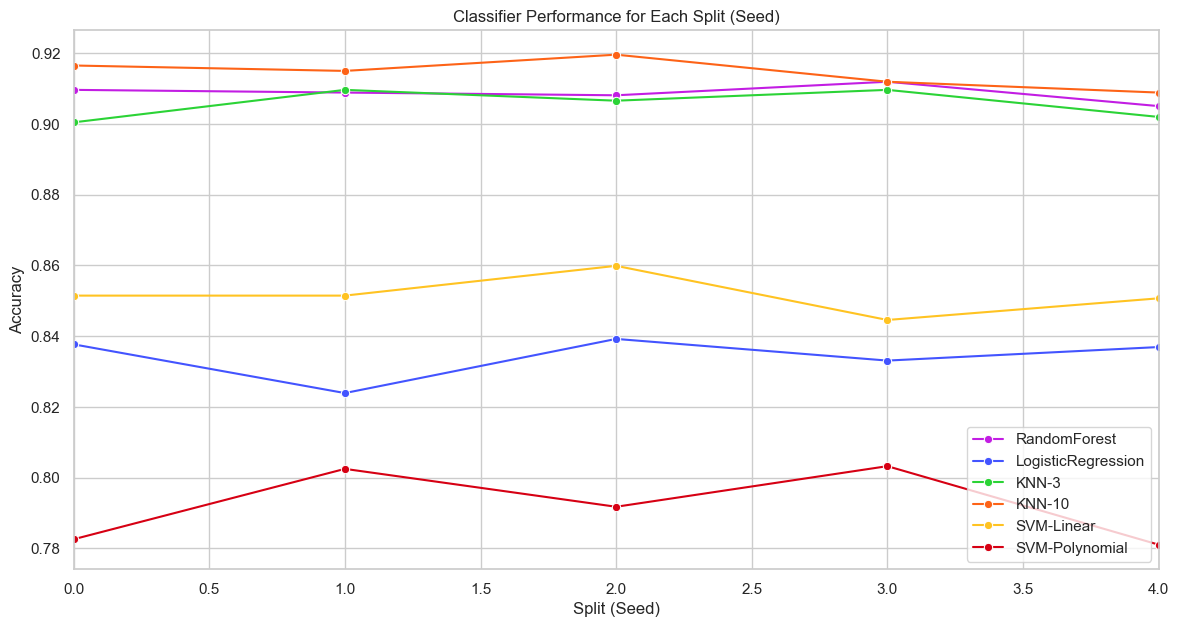

In [370]:
results_list1 = []
for seed, results in enumerate(all_results_all_metrics):
    for name, metrics in results.items():
        results_list1.append({
            'Seed': seed,
            'Classifier': name,
            'Accuracy': metrics['accuracy']
        })

# Convert results_list to a DataFrame
results_df = pd.DataFrame(results_list1)

# Plot the data
plt.figure(figsize=(14, 7))
colors = ['#C21DE3', '#4354FF','#2BD336', '#FD6317', '#FFC322', '#D60013']
sns.lineplot(x='Seed', y='Accuracy', hue='Classifier', data=results_df, palette=colors, marker='o', ci=None)

plt.title('Classifier Performance for Each Split (Seed)')
plt.xlabel('Split (Seed)')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xlim([0, 4])
plt.show()

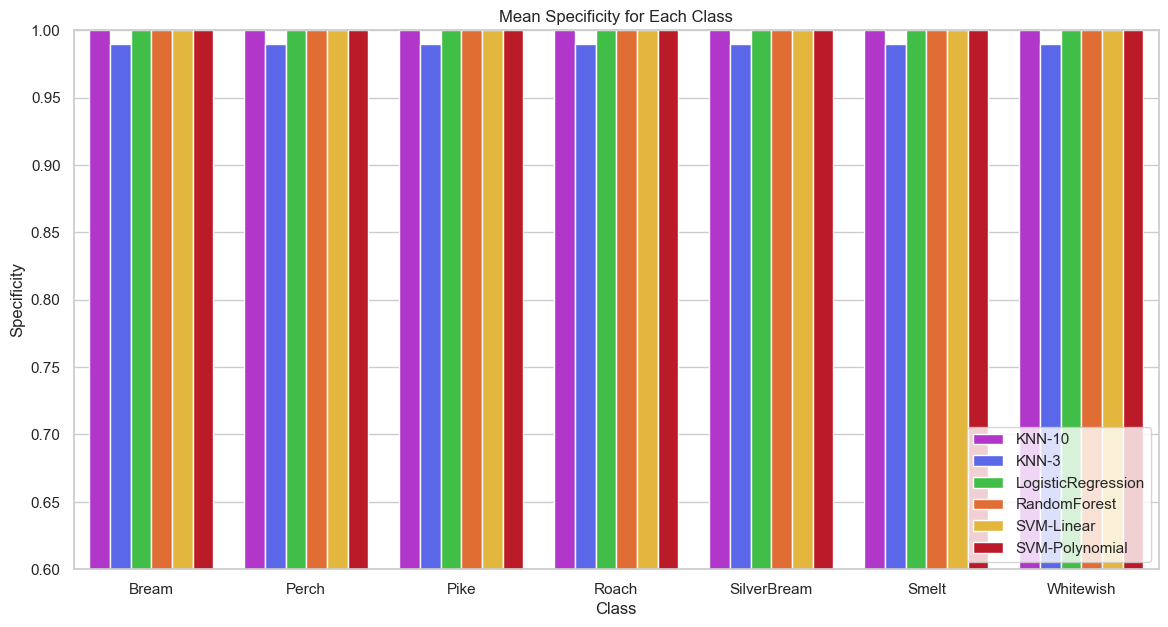

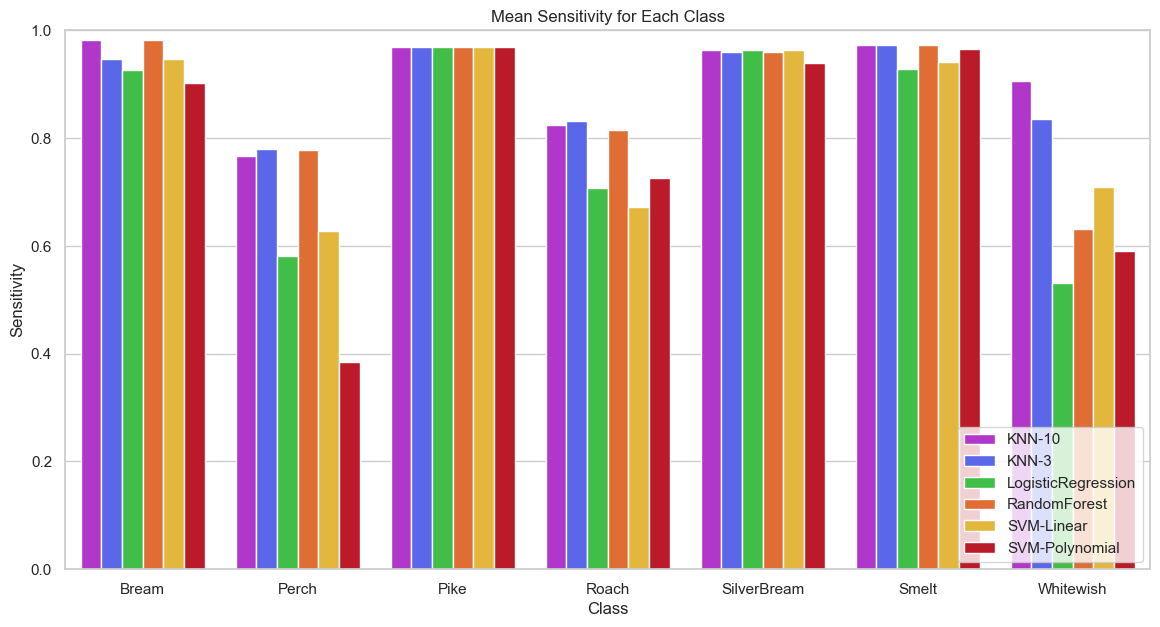

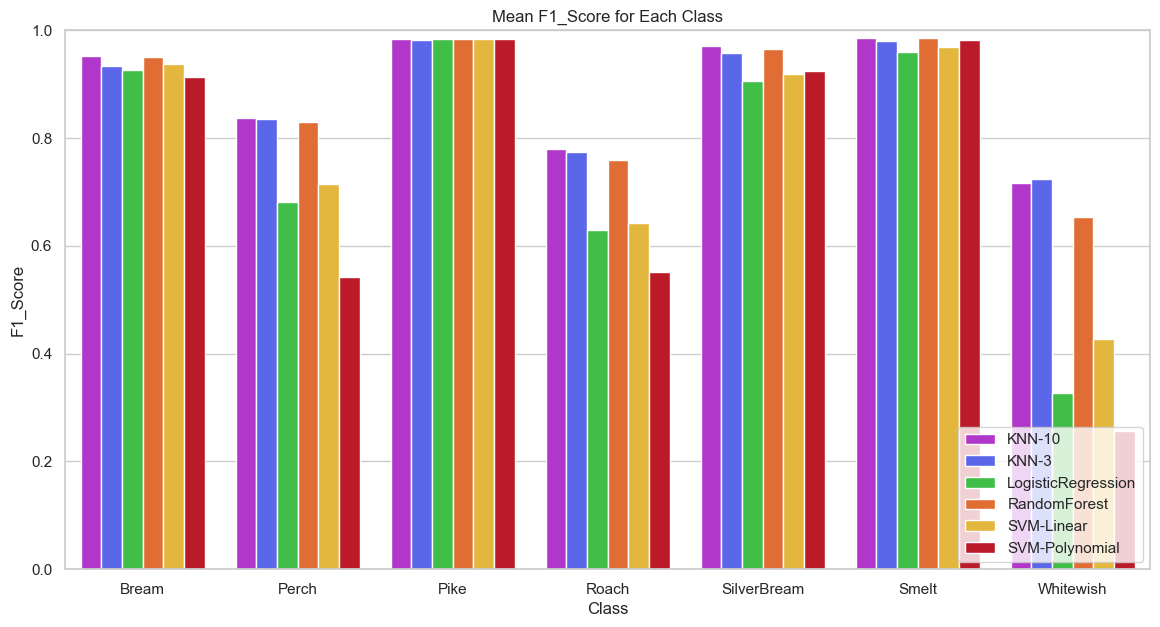

In [325]:
# Initialize lists to store results
specificity_list = []
sensitivity_list = []
f1_list = []
# Extract specificities and sensitivities from all_results
for seed, results in enumerate(all_results_all_metrics):
    for name, metrics in results.items():
        for class_label in ['Bream', 'Perch', 'Pike', 'Roach', 'SilverBream', 'Smelt', 'Whitewish']:
            specificity_list.append({
                'Seed': seed,
                'Classifier': name,
                'Class': class_label,
                'Specificity': metrics[f'{class_label}_specificity']
            })
            sensitivity_list.append({
                'Seed': seed,
                'Classifier': name,
                'Class': class_label,
                'Sensitivity': metrics[f'{class_label}_sensitivity']
            })
            f1_list.append({
                'Seed': seed,
                'Classifier': name,
                'Class': class_label,
                'F1_Score': metrics[f'{class_label}_f1']
            })

# Convert lists to DataFrames
specificity_df = pd.DataFrame(specificity_list)
sensitivity_df = pd.DataFrame(sensitivity_list)
f1_df = pd.DataFrame(f1_list)

# Calculate mean specificity and sensitivity for each class and classifier
mean_specificity = specificity_df.groupby(['Classifier', 'Class'])['Specificity'].mean().reset_index()
mean_sensitivity = sensitivity_df.groupby(['Classifier', 'Class'])['Sensitivity'].mean().reset_index()
mean_f1 = f1_df.groupby(['Classifier', 'Class'])['F1_Score'].mean().reset_index()

# Plot mean specificity
plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='Specificity', hue='Classifier', data=mean_specificity, palette=colors)
plt.title('Mean Specificity for Each Class')
plt.xlabel('Class')
plt.ylabel('Specificity')
plt.legend(loc='lower right')
plt.ylim(0.6,1.0)
plt.show()

# Plot mean sensitivity
plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='Sensitivity', hue='Classifier', data=mean_sensitivity, palette=colors)
plt.title('Mean Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0,1.0)
plt.legend(loc='lower right')
plt.show()
 
 #plot the f1 performance 
plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='F1_Score', hue='Classifier', data=mean_f1, palette=colors)
plt.title('Mean F1_Score for Each Class')
plt.xlabel('Class')
plt.ylabel('F1_Score')
plt.ylim(0,1.0)
plt.legend(loc='lower right')
plt.show() 




### 1b
Which set of features are optimal classification performance? Does this differ for different classifiers in 1a? Does this differ between the classes? 

Does this vary between observations, e.g., between correctly labeled and the mislabeled observations?

Use at least 3 different methods to answer the above questions. Discuss the stability of selection and the confidence you can attach to your estimate of the number of features needed or features selected, and how you assessed this.

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=seed)
print("X_train shape:" , X_train.shape)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


X_train shape: (1306, 6)


In [6]:

# Define the feature selection methods
def get_anova_importances(X_data, y_data) -> np.ndarray:
    f_values, _ = f_classif(X_data, y_data)
    return f_values

def get_lasso_importances(X_data, y_data, l1=0.1, seed=None) -> np.ndarray:
    lasso_logreg = LogisticRegression(penalty="l1", solver='liblinear', random_state=seed, C=1/l1)
    lasso_logreg.fit(X_data, y_data)
    importances = np.mean(np.abs(lasso_logreg.coef_), axis=0)
    return importances

def get_elastic_importances(X_data, y_data, l1=0.1, l2=0.1, seed=None) -> np.ndarray:
    elastic_logreg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=l1, C=1/l2, random_state=seed)
    elastic_logreg.fit(X_data, y_data)
    importances = np.mean(np.abs(elastic_logreg.coef_), axis=0)
    return importances

# Initialize lists for feature selection and analysis
features = list(X_train.columns)
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
print("Number of features:", len(features))

num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
f_means = []
lasso_means = []
elastic_means = []
feature_freq = defaultdict(lambda: np.zeros(len(features)))
num_features = len(features)

# Get importances from cross-validation
for train_index, test_index in skf.split(X_train, target_train):
    X_fold, y_fold = X_train.iloc[train_index], target_train.iloc[train_index]
    
    # Apply feature selection methods
    selected_anova = get_anova_importances(X_fold, y_fold)
    selected_lasso = get_lasso_importances(X_fold, y_fold, seed=42)
    selected_elastic = get_elastic_importances(X_fold, y_fold, seed=42)
    
    f_means.append(selected_anova)
    lasso_means.append(selected_lasso)
    elastic_means.append(selected_elastic)
    
# Convert means to arrays
f_means = np.array(f_means)
lasso_means = np.array(lasso_means)
elastic_means = np.array(elastic_means)

# Normalize importances
f_means = f_means / f_means.max(axis=1)[:, np.newaxis]
lasso_means = lasso_means / lasso_means.max(axis=1)[:, np.newaxis]
elastic_means = elastic_means / elastic_means.max(axis=1)[:, np.newaxis]

# Calculate means and standard deviations
f_means_mean = f_means.mean(axis=0)
f_means_std = f_means.std(axis=0)
lasso_means_mean = lasso_means.mean(axis=0)
lasso_means_std = lasso_means.std(axis=0)
elastic_means_mean = elastic_means.mean(axis=0)
elastic_means_std = elastic_means.std(axis=0)

# Store results in dictionary
features_dict = {}
for i, feature in enumerate(features):
    features_dict[feature] = {
        "cv_anova_values": f_means_mean[i],
        "cv_anova_std": f_means_std[i],
        "cv_lasso_values": lasso_means_mean[i],
        "cv_lasso_std": lasso_means_std[i],
        "cv_elastic_values": elastic_means_mean[i],
        "cv_elastic_std": elastic_means_std[i],
    }

print(features_dict["Weight"]["cv_anova_values"])


Number of features: 6
0.08256217779004923


In [7]:

from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKFold object

# e top 3 features from the ANOVA method
elastic_top_features = sorted(features_dict, key=lambda x: (features_dict[x]['cv_elastic_values']), reverse=True)[:3]
lasso_top_features = sorted(features_dict, key=lambda x: (features_dict[x]['cv_lasso_values']), reverse=True)[:3]
anova_top_features = sorted(features_dict, key=lambda x: (features_dict[x]['cv_anova_values']), reverse=True)[:3]
# this part is for the analysis of the classifiers specific optimal features
print("Elastic top features:", elastic_top_features)    
print("lasso top features:", lasso_top_features)
print("ANOVA top features:", anova_top_features)

# Select only the top features from the data

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3, random_state=42)



X_train_elastic = X_train[elastic_top_features]
X_test_elastic = X_test[elastic_top_features]
X_train_lasso = X_train[lasso_top_features]
X_test_lasso = X_test[lasso_top_features]
X_train_anova = X_train[anova_top_features]
X_test_anova = X_test[anova_top_features]
print(X_train_lasso.head())
print(X_test_lasso.head())


classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-10': KNeighborsClassifier(n_neighbors=10),
    'SVM-Linear': SVC(kernel='linear'),
    'SVM-Polynomial': SVC(kernel='poly', degree=3)
}

feature_selection_methods = {
    'Elastic': (X_train_elastic, X_test_elastic),
    'Lasso' : (X_train_lasso, X_test_lasso),
    'anova': (X_train_anova, X_test_anova)
}


stratified_kfold = StratifiedKFold(n_splits=5)
scoring = 'f1_weighted'
results_clf_fs = {}
for method, (X_train_selected, X_test_selected) in feature_selection_methods.items():
    for classifier_name, clf in classifiers.items():
        pipeline = Pipeline([('SMOTE', SMOTE(random_state=42)), ('Scaler', StandardScaler()), ('Classifier', clf)])
        scores = cross_val_score(pipeline, X_train_selected, target_train, cv=stratified_kfold, scoring=scoring)
        
        results_clf_fs[(method, classifier_name)] = {
            'mean_f1_score': scores.mean(),
            'std_f1_score': scores.std()
        }

# Print the results
for (method, classifier_name), score_info in results_clf_fs.items():
    print(f'{method} + {classifier_name}: Mean F1 Score = {score_info["mean_f1_score"]}, Std Dev = {score_info["std_f1_score"]}')


Elastic top features: ['Height', 'L3', 'Width']
lasso top features: ['L3', 'Height', 'Weight']
ANOVA top features: ['Height', 'Width', 'L3']
             L3     Height      Weight
1377  43.145068  40.126061  947.535229
209   14.389054  16.793754   -2.638026
1310  37.399795  39.235332  604.242950
1461  47.040774  16.570562  525.434767
59    42.032484  14.925998  336.459379
             L3     Height      Weight
1698  11.984178  17.282864   69.780646
1681  12.797774  17.494385   12.693852
922   27.374527  27.986540  261.089286
276   20.397529  36.932156  126.513896
417   40.088287  29.073272  777.010171
Elastic + RandomForest: Mean F1 Score = 0.9116660472897745, Std Dev = 0.008047670787709306
Elastic + LogisticRegression: Mean F1 Score = 0.8360129646034101, Std Dev = 0.023384422716140153
Elastic + KNN-3: Mean F1 Score = 0.8989069204507425, Std Dev = 0.007290943940268952
Elastic + KNN-10: Mean F1 Score = 0.8993217280693614, Std Dev = 0.00705174832475946
Elastic + SVM-Linear: Mean F1 Score

In order to Train different classifiers using the top features from each method and compare their performance:

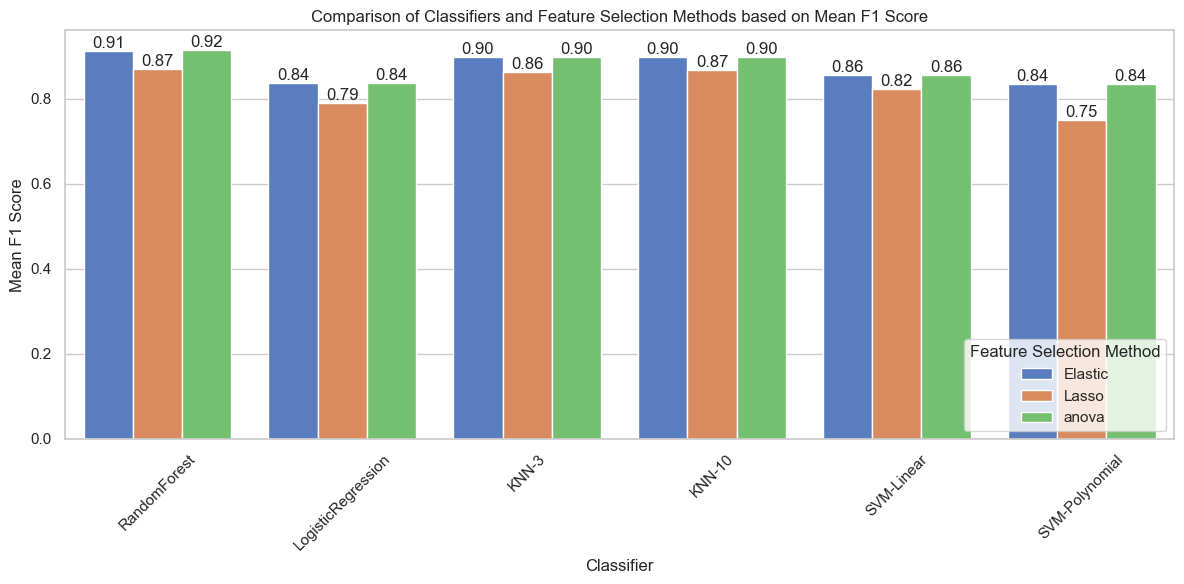

In [11]:
import pandas as pd

results_data = []

for (method, classifier_name), score_info in results_clf_fs.items():
    results_data.append({
        'Feature Selection Method': method,
        'Classifier': classifier_name,
        'Mean F1 Score': score_info['mean_f1_score'],
        'Std Dev': score_info['std_f1_score']
    })

results_df = pd.DataFrame(results_data)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

barplot = sns.barplot(x='Classifier', y='Mean F1 Score', hue='Feature Selection Method', data=results_df, palette='muted',)

plt.title('Comparison of Classifiers and Feature Selection Methods based on Mean F1 Score')
plt.xlabel('Classifier')
plt.ylabel('Mean F1 Score')
plt.legend(title='Feature Selection Method', loc='lower right')
plt.xticks(rotation=45)

for bar in barplot.containers:
    barplot.bar_label(bar, fmt='%.2f')
plt.tight_layout()

plt.show()

In [15]:
#Comparing top features for each classifier
for classifier_name, clf in classifiers.items():
    print(f'Classifier: {classifier_name}')
    for method in feature_selection_methods.keys():
        top_features = sorted(features_dict, key=lambda x: features_dict[x][f'cv_{method.lower()}_values'], reverse=True)
        print(f'  Method: {method}, Top Features: {top_features}')

Classifier: RandomForest
  Method: Elastic, Top Features: ['Height', 'L3', 'Width', 'Weight', 'L2', 'L1']
  Method: Lasso, Top Features: ['L3', 'Height', 'Weight', 'L2', 'L1', 'Width']
  Method: anova, Top Features: ['Height', 'Width', 'L3', 'L2', 'L1', 'Weight']
Classifier: LogisticRegression
  Method: Elastic, Top Features: ['Height', 'L3', 'Width', 'Weight', 'L2', 'L1']
  Method: Lasso, Top Features: ['L3', 'Height', 'Weight', 'L2', 'L1', 'Width']
  Method: anova, Top Features: ['Height', 'Width', 'L3', 'L2', 'L1', 'Weight']
Classifier: KNN-3
  Method: Elastic, Top Features: ['Height', 'L3', 'Width', 'Weight', 'L2', 'L1']
  Method: Lasso, Top Features: ['L3', 'Height', 'Weight', 'L2', 'L1', 'Width']
  Method: anova, Top Features: ['Height', 'Width', 'L3', 'L2', 'L1', 'Weight']
Classifier: KNN-10
  Method: Elastic, Top Features: ['Height', 'L3', 'Width', 'Weight', 'L2', 'L1']
  Method: Lasso, Top Features: ['L3', 'Height', 'Weight', 'L2', 'L1', 'Width']
  Method: anova, Top Features:

In [434]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

class_labels = np.unique(target)
class_feature_importance = {}

for class_label in class_labels:
    y_binary = (target == class_label).astype(int)
    anova_importances = get_anova_importances(X, y_binary)
    lasso_importances = get_lasso_importances(X, y_binary, seed=42)
    elastic_importances = get_elastic_importances(X, y_binary, seed=42)
    
    class_feature_importance[class_label] = {
        'ANOVA': X.columns[np.argsort(anova_importances)[-4:]].tolist(),
        'Lasso': X.columns[np.argsort(lasso_importances)[-4:]].tolist(),
        'Elastic': X.columns[np.argsort(elastic_importances)[-4:]].tolist()
    }
    
for label, features in class_feature_importance.items():
    print(f"Class {label} - ANOVA top features: {features['ANOVA']}")
    print(f"Class {label} - Lasso top features: {features['Lasso']}")
    print(f"Class {label} - Elastic Net top features: {features['Elastic']}")


Class Bream - ANOVA top features: ['L2', 'L3', 'Weight', 'Height']
Class Bream - Lasso top features: ['L1', 'Width', 'L3', 'Height']
Class Bream - Elastic Net top features: ['Width', 'L2', 'L1', 'Height']
Class Perch - ANOVA top features: ['Weight', 'L3', 'Height', 'Width']
Class Perch - Lasso top features: ['Height', 'L2', 'L3', 'Width']
Class Perch - Elastic Net top features: ['L1', 'L3', 'Height', 'Width']
Class Pike - ANOVA top features: ['Width', 'Height', 'L2', 'L1']
Class Pike - Lasso top features: ['L1', 'L2', 'L3', 'Width']
Class Pike - Elastic Net top features: ['L1', 'L2', 'Width', 'Height']
Class Roach - ANOVA top features: ['L1', 'L3', 'L2', 'Weight']
Class Roach - Lasso top features: ['Height', 'L2', 'L3', 'Width']
Class Roach - Elastic Net top features: ['Weight', 'L1', 'L2', 'Height']
Class SilverBream - ANOVA top features: ['L3', 'L2', 'L1', 'Height']
Class SilverBream - Lasso top features: ['Width', 'L1', 'L3', 'Height']
Class SilverBream - Elastic Net top features: [

In [14]:
from sklearn.utils import resample

def evaluate_stability(X_train, y_train, feature_selection_func, num_iterations=100):
    selected_features = []
    for i in range(num_iterations):
        X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
        selected_features.append(feature_selection_func(X_resampled, y_resampled))
    
    # Count frequency of each feature being selected
    feature_counts = np.zeros(X_train.shape[1])
    for features in selected_features:
        feature_counts[features] += 1
    
    return feature_counts / num_iterations

# Calculate stability for each method
anova_stability = evaluate_stability(X_train, target_train, lambda X, y: np.argsort(get_anova_importances(X, y))[-3:])
lasso_stability = evaluate_stability(X_train, target_train, lambda X, y: np.argsort(get_lasso_importances(X, y))[-3:])
elastic_stability = evaluate_stability(X_train, target_train, lambda X, y: np.argsort(get_elastic_importances(X, y))[-3:])


<BarContainer object of 6 artists> <BarContainer object of 6 artists> <BarContainer object of 6 artists>


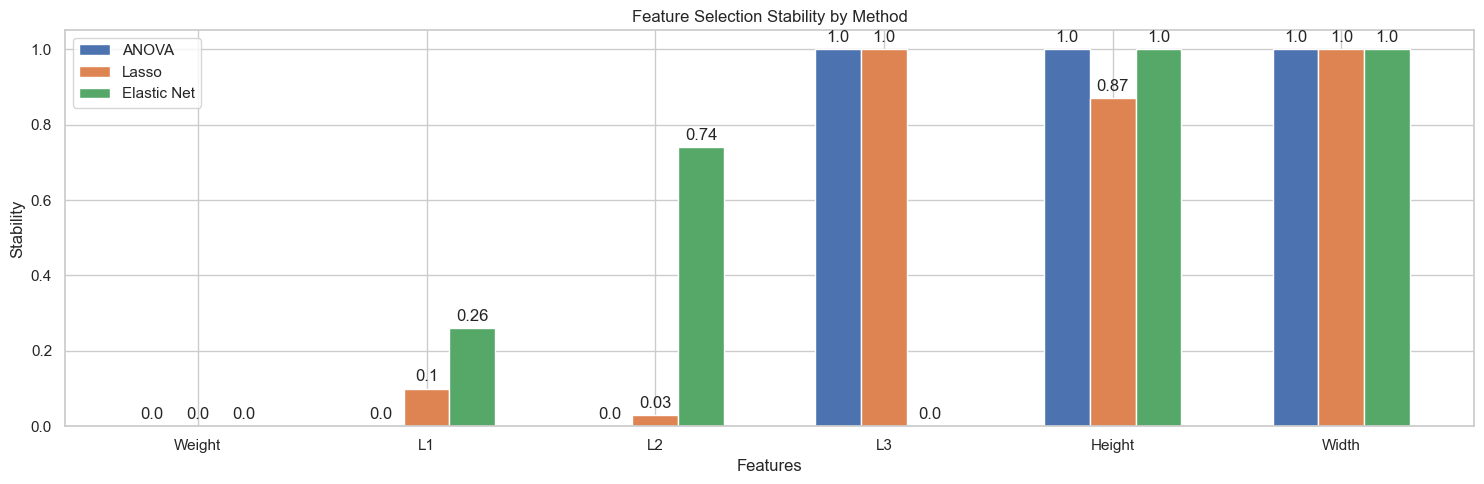

In [17]:
import numpy as np
import matplotlib.pyplot as plt



features = X_train.columns
x = np.arange(len(features))

width = 0.2  

fig, ax = plt.subplots(figsize=(15, 5))


rects1 = ax.bar(x - width, anova_stability, width, label='ANOVA')
rects2 = ax.bar(x, lasso_stability, width, label='Lasso')
rects3 = ax.bar(x + width, elastic_stability, width, label='Elastic Net')


ax.set_xlabel('Features')
ax.set_ylabel('Stability')
ax.set_title('Feature Selection Stability by Method')

ax.set_xticks(x)
ax.set_xticklabels(features)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Show plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.175  0.825  1.825  2.825  3.825  4.825]
[0.48546379870762724, 0.3889376736216773, 0.4016795014778827, 1.0, 0.5826985181077113, 0.3389936669183913]
6
6


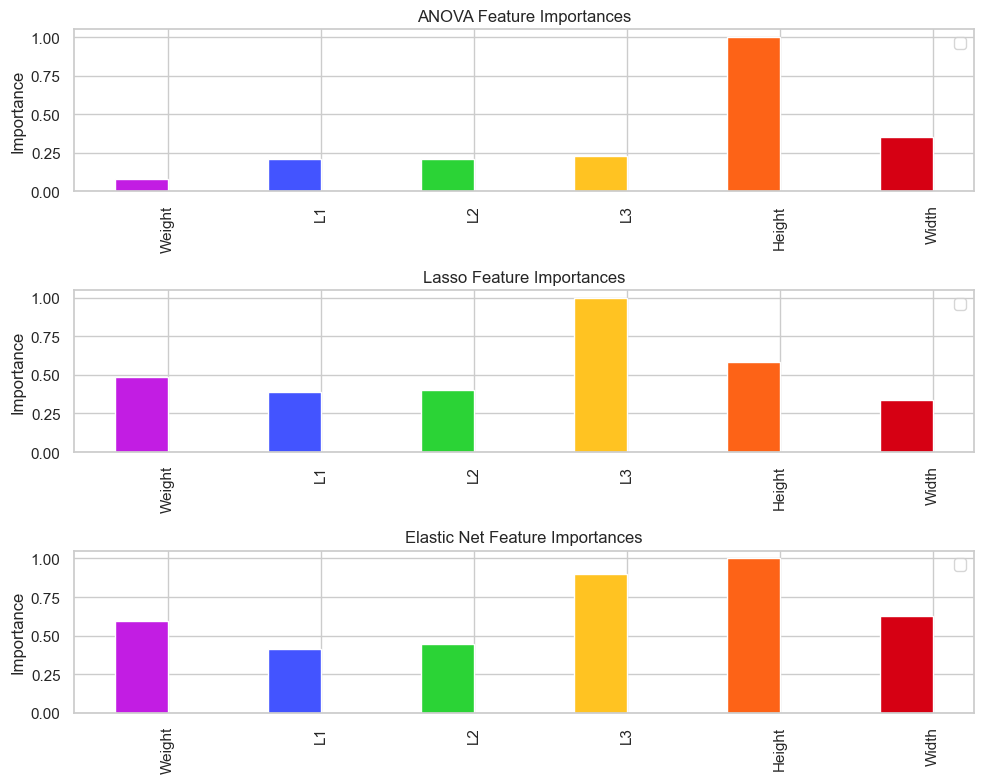

In [432]:
features_range = np.arange(len(features)) 
bar_width = 0.35
colors = ['#C21DE3', '#4354FF','#2BD336', '#FFC322','#FD6317',  '#D60013']
colors1 = ['#E475FA', '#7FB7FF','#60F769', '#FEE73A', '#FFC322', '#FF5733']
plt.figure(figsize=(10, 8))

# ANOVA
plt.subplot(3, 1, 1)
plt.bar(features_range - bar_width/2, [features_dict[feature]["cv_anova_values"] for feature in features], bar_width, color=colors)
plt.xticks(features_range, features, rotation='vertical')
plt.title("ANOVA Feature Importances")
plt.ylabel("Importance")
plt.legend()
print(features_range - bar_width/2)
print([features_dict[feature]["cv_lasso_values"] for feature in features])
print(len(features_range - bar_width/2))
print(len([features_dict[feature]["cv_lasso_values"] for feature in features]))


# Lasso
plt.subplot(3, 1, 2)
for i, feature in enumerate(features):
    plt.bar(i - bar_width/2, features_dict[feature]["cv_lasso_values"], bar_width, color=colors[i])
plt.xticks((features_range), features, rotation='vertical')
plt.title("Lasso Feature Importances")
plt.ylabel("Importance")
plt.legend()

# Elastic Net
plt.subplot(3, 1, 3)
for i, feature in enumerate(features):
    plt.bar(i - bar_width/2, features_dict[feature]["cv_elastic_values"], bar_width, color=colors[i])
plt.xticks(features_range, features, rotation='vertical')
plt.title("Elastic Net Feature Importances")
plt.ylabel("Importance")
plt.legend()

plt.tight_layout()
plt.show()

to check which calss is picked the most with combination of the classifiers and the feature selections

In [396]:
from collections import Counter

# Store the results and most common classes in dictionaries
results = {}
most_common_classes = {}

# For each combination of feature selection method and classifier
for method, (X_train_selected, X_test_selected) in feature_selection_methods.items():
    for classifier_name, clf in classifiers.items():
        
        clf.fit(X_train_selected, target_train)
        
        predictions = clf.predict(X_test_selected)
        
        class_counts = Counter(predictions)
        
        most_common_classes[(method, classifier_name)] = class_counts.most_common(1)[0]
        
        scores = cross_val_score(clf, X_train_selected, target_train, cv=5)
        
        results[(method, classifier_name)] = {
            'mean_score': scores.mean(),
            'std_score': scores.std()
        }

# Print the results and most common classes
for (method, classifier_name), score_info in results.items():
    most_common_class = most_common_classes[(method, classifier_name)]
    print(f'{method} + {classifier_name}: Most common class {most_common_class}')
    print(f'{method} + {classifier_name}: Mean Score = {score_info["mean_score"]}, Std Dev = {score_info["std_score"]}, Most Common Class = {most_common_class[0]} with a count of {most_common_class[1]}')

Elastic + RandomForest: Most common class ('Bream', 165)
Elastic + RandomForest: Mean Score = 0.9157819309174929, Std Dev = 0.014070723025835855, Most Common Class = Bream with a count of 165
Elastic + LogisticRegression: Most common class ('Bream', 166)
Elastic + LogisticRegression: Mean Score = 0.8614108976046329, Std Dev = 0.0218484889717234, Most Common Class = Bream with a count of 166
Elastic + KNN-3: Most common class ('Bream', 165)
Elastic + KNN-3: Mean Score = 0.907358661636103, Std Dev = 0.01214401004597013, Most Common Class = Bream with a count of 165
Elastic + KNN-10: Most common class ('Bream', 164)
Elastic + KNN-10: Mean Score = 0.8996929016407826, Std Dev = 0.01462453391965976, Most Common Class = Bream with a count of 164
Elastic + SVM-Linear: Most common class ('Bream', 165)
Elastic + SVM-Linear: Mean Score = 0.8698253926471878, Std Dev = 0.0176827692846659, Most Common Class = Bream with a count of 165
Elastic + SVM-Polynomial: Most common class ('Perch', 182)
Elasti

no we want to check the impact of the feature on the classifiers performances 

In [400]:
from sklearn.linear_model import LogisticRegression


clf_per_class = LogisticRegression(multi_class='multinomial', max_iter=1000)
clf_per_class.fit(X_train, target_train)

feature_names = X_train.columns.tolist()  
class_labels = np.unique(target_train)


feature_importances_logistic = clf_per_class.coef_
importances_dict_logistic = {}
 
for i, class_feature_importances in enumerate(feature_importances_logistic):
    
    class_importances = {}

    for j, importance in enumerate(class_feature_importances):

        class_importances[feature_names[j]] = importance


    importances_dict_logistic[class_labels[i]] = class_importances
    
for i, class_feature_importances in enumerate(feature_importances_logistic):
    print(f'Feature importances for class {class_labels[i]}:')
    for j, importance in enumerate(class_feature_importances):
        print(f'    {feature_names[j]}: {importance}')

Feature importances for class Bream:
    Weight: -0.0013544730067662249
    L1: 0.26018482422985434
    L2: -0.033721373504106956
    L3: 0.027477373918750908
    Height: 0.41534507606944515
    Width: -1.2290950877347988
Feature importances for class Perch:
    Weight: 0.007098049188191122
    L1: 0.005963770062995631
    L2: 0.1568755905494219
    L3: -0.27295685724119134
    Height: -0.46223685118273583
    Width: 1.3848964373097592
Feature importances for class Pike:
    Weight: -0.02005550671591129
    L1: 0.17379586441512723
    L2: 0.2022886230728466
    L3: 0.7803127984313283
    Height: 0.027159113357738046
    Width: -2.1782954139974278
Feature importances for class Roach:
    Weight: -0.0016363853782271726
    L1: -0.11831818510056007
    L2: -0.21254839796826788
    L3: 0.32568772565749016
    Height: -0.308828975655591
    Width: 0.926739011184391
Feature importances for class SilverBream:
    Weight: 0.008533853292505153
    L1: 0.20958717017477535
    L2: -0.078929366673